<a href="https://colab.research.google.com/github/khalidpark/project-LogSecurity/blob/main/project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기 및 간단 EDA

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
train=pd.read_csv('/content/train.csv', error_bad_lines=False, engine="python")

In [ ]:
print(train.shape)

(472972, 3)


In [ ]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [ ]:
train.dtypes

id           int64
level        int64
full_log    object
dtype: object

In [ ]:
#로그 데이터 프린트 후 구성 확인
print(train['full_log'][0])

Sep 24 10:02:22 localhost kibana: {"type":"error","@timestamp":"2020-09-24T01:02:22Z","tags":["warning","stats-collection"],"pid":6458,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:226:15)\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:214:7)\n    at process._tickCallback (internal/process/next_tick.js:61:11)"},"message":"No Living connections"}


In [ ]:
##로그 데이터 프린트 후 구성 확인
print(train['full_log'][1])

Feb  8 16:21:00 localhost logstash: [2021-02-08T16:21:00,548][INFO ][logstash.outputs.elasticsearch] retrying failed action with response code: 503 ({"type"=>"unavailable_shards_exception", "reason"=>"[wazuh-alerts-audit-3.x-2021.16.08][3] primary shard is not active Timeout: [1m], request: [BulkShardRequest [[wazuh-alerts-audit-3.x-2021.16.08][3]] containing [25] requests]"})


### full_log 분석

full log는 딕셔너리 형식

데이터의 형식이고정되어있지 않아, 위험 키워드를 특정하거나 수치만을 활용하는 방법이 필요하다 판단됨.


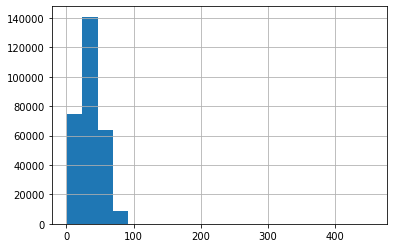

In [ ]:
#train full_log의 길이 확인
train['full_log'].str.split(' ').str.len().hist(bins=20)

In [ ]:
#train level별 값 확인
train['level'].value_counts()

0    203887
1     80791
3      2524
5      1343
4         6
6         5
2         4
Name: level, dtype: int64

### 분포분석

보안위험이 0 인 분포의 비율이 70%이므로 분포의 가중치를 유의하여 모델에 적용해야함



---



# 데이터전처리 및 모델링

### 방법1) 숫자 마스킹 처리 -> CountVectorizer -> Randomforest

In [ ]:
train_1 = train.copy()

In [ ]:
#full_log에서 숫자는 마스킹 처리
train_1['full_log']=train_1['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
#마스킹 전 후 비교
print(train['full_log'][0])
print(train_1['full_log'][0])

Sep 24 10:02:22 localhost kibana: {"type":"error","@timestamp":"2020-09-24T01:02:22Z","tags":["warning","stats-collection"],"pid":6458,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:226:15)\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:214:7)\n    at process._tickCallback (internal/process/next_tick.js:61:11)"},"message":"No Living connections"}
Sep <num><num> <num><num>:<num><num>:<num><num> localhost kibana: {"type":"error","@timestamp":"<num><num><num><num>-<num><num>-<num><num>T<num><num>:<num><num>:<num><num>Z","tags":["warning","stats-collection"],"pid":<num><num><num><num>,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:<n

In [ ]:
#train['full_log'] => train_text로 list
#train['level']=> train_level로 array
train_text_1=list(train_1['full_log'])
train_level_1=np.array(train_1['level'])

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features_1=vectorizer.fit_transform(train_text_1)

In [ ]:
train_features_1

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_1,x_val_1, y_train_1, y_val_1=train_test_split(train_features_1, train_level_1, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [ ]:
#랜덤포레스트로 모델링
from sklearn.ensemble import RandomForestClassifier

model_1=RandomForestClassifier(n_estimators=100)

model_1.fit(x_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#모델 검증
model_1.score(x_val_1, y_val_1)

0.9979174374966965

In [ ]:
#crosstab으로 확인
pred_1=model_1.predict(x_val_1)
crosstab_1 = pd.crosstab(y_val_1, pred_1, rownames=['real'], colnames=['pred'])
crosstab_1

pred,0,1,2,3,4,5
real,,,,,,
0,66729,55,0,0,0,2
1,119,26427,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,12,3,0,0,0,438
6,1,0,0,2,0,0


###### score : 0.9979174374966965

### 방법2) 숫자 마스킹 처리 -> TfidfVectorizer -> Randomforest

In [ ]:
train_2 = train.copy()

In [ ]:
train_2['full_log']=train_2['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Tfidf 기반 피쳐 벡터화 변환
tfidf_vec = TfidfVectorizer(min_df=0,ngram_range=(2,2),max_features=10000)
train_text_2 = tfidf_vec.fit_transform(train_2['full_log'])
train_level_2=np.array(train_2['level'])


In [ ]:
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_2,x_val_2, y_train_2, y_val_2=train_test_split(train_text_2, train_level_2, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_2=RandomForestClassifier(n_estimators=100)

model_2.fit(x_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#방법1의 vectorize 이 더 우수한걸로 파악됨

model_2.score(x_val_2, y_val_2)

0.9978962947301654

In [ ]:
#crosstab으로 확인
pred_2=model_2.predict(x_val_2)
crosstab_2 = pd.crosstab(y_val_2, pred_2, rownames=['real'], colnames=['pred'])
crosstab_2

pred,0,1,2,3,4,5
real,,,,,,
0,66726,59,0,0,0,1
1,119,26428,0,0,0,0
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,13,2,0,0,0,438
6,1,0,0,2,0,0


###### score : 0.9978962947301654

### =>  Vectorrizer 비교 결과 : Countervectorizer의 성능 더 우수



---



### 방법3) 숫자 마스킹 처리 -> Countervectorizer -> XGBClassifier

In [ ]:
train_3 = train.copy()

In [ ]:
# 숫자 마스킹 작업
train_3['full_log']=train_3['full_log'].str.replace(r'[0-9]', '<num>')

print(train_3['full_log'][0])

Sep <num><num> <num><num>:<num><num>:<num><num> localhost kibana: {"type":"error","@timestamp":"<num><num><num><num>-<num><num>-<num><num>T<num><num>:<num><num>:<num><num>Z","tags":["warning","stats-collection"],"pid":<num><num><num><num>,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:<num><num><num>:<num><num>)\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:<num><num><num>:<num>)\n    at process._tickCallback (internal/process/next_tick.js:<num><num>:<num><num>)"},"message":"No Living connections"}


In [ ]:
print(train_3['full_log'])

0         Sep <num><num> <num><num>:<num><num>:<num><num...
1         Feb  <num> <num><num>:<num><num>:<num><num> lo...
2         Jan <num><num> <num><num>:<num><num>:<num><num...
3         Jan  <num> <num><num>:<num><num>:<num><num> lo...
4         type=SYSCALL msg=audit(<num><num><num><num><nu...
                                ...                        
472967    Feb <num><num> <num><num>:<num><num>:<num><num...
472968    type=SYSCALL msg=audit(<num><num><num><num><nu...
472969    Oct <num><num> <num><num>:<num><num>:<num><num...
472970    Jan <num><num> <num><num>:<num><num>:<num><num...
472971    Oct <num><num> <num><num>:<num><num>:<num><num...
Name: full_log, Length: 472972, dtype: object


In [ ]:
train_text_3=list(train_3['full_log'])
train_level_3=np.array(train_3['level'])

In [ ]:
train_text_3[0]

'Sep <num><num> <num><num>:<num><num>:<num><num> localhost kibana: {"type":"error","@timestamp":"<num><num><num><num>-<num><num>-<num><num>T<num><num>:<num><num>:<num><num>Z","tags":["warning","stats-collection"],"pid":<num><num><num><num>,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:<num><num><num>:<num><num>)\\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:<num><num><num>:<num>)\\n    at process._tickCallback (internal/process/next_tick.js:<num><num>:<num><num>)"},"message":"No Living connections"}'

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features_3=vectorizer.fit_transform(train_text_3)
train_features_3

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

In [ ]:
# train_text_3[0] = [train_text_3[0]]
# train_features_33=vectorizer.transform(train_text_3[0])
# train_features_33

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_3,x_val_3, y_train_3, y_val_3=train_test_split(train_features_3, train_level_3, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [ ]:
from xgboost import XGBClassifier

In [ ]:
# XGBClassifier

model_3 = XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.8, 
                    colsample_bytree=0.7, 
                    gamma=0, 
                    max_depth=5, learning_rate=0.15,
                    n_estimators=100, 
                    nthread=4,
                    objective = 'multi:softmax',
                    silent= False,
                    random_state = 42)

model_3.fit(x_train_3, y_train_3, eval_set=[(x_val_3, y_val_3)],early_stopping_rounds=10)

[0]	validation_0-merror:0.002749
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.002231
[2]	validation_0-merror:0.001882
[3]	validation_0-merror:0.001966
[4]	validation_0-merror:0.001945
[5]	validation_0-merror:0.001956
[6]	validation_0-merror:0.001956
[7]	validation_0-merror:0.001966
[8]	validation_0-merror:0.001956
[9]	validation_0-merror:0.001977
[10]	validation_0-merror:0.001966
[11]	validation_0-merror:0.001892
[12]	validation_0-merror:0.001892
Stopping. Best iteration:
[2]	validation_0-merror:0.001882



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

In [ ]:
#모델 검증
model_3.score(x_val_3, y_val_3)

0.998118293778741

In [ ]:
#crosstab으로 확인
pred_3 = model_3.predict(x_val_3)
crosstab_3 = pd.crosstab(y_val_3, pred_3, rownames=['real'], colnames=['pred'])
crosstab_3

pred,0,1,2,3,4,5
real,,,,,,
0,66785,1,0,0,0,0
1,145,26402,0,0,0,0
2,0,0,2,0,0,0
3,9,0,0,792,0,0
4,0,0,0,0,3,0
5,20,0,0,0,0,433
6,1,0,0,2,0,0


###### score : 0.998118293778741



---



In [ ]:
# text_raw = input()
# print(text_raw)
# print('-------------------------------------------------')
# data = {'id': 0,'level': 0,'full_log': [text_raw]}
# df = pd.DataFrame(data)
# print(df.head(5))
# print('-------------------------------------------------')
# df['full_log']=df['full_log'].str.replace(r'[0-9]', '<num>')
# test_text=list(df['full_log'])
# print(test_text)
# print('-------------------------------------------------')


# vectorizer=CountVectorizer(analyzer="word", max_features=10000)
# test_features=vectorizer.fit_transform(test_text)
# print(test_features)


# predict = model_3.predict(test_features)

In [ ]:
# text = "Sep 24 10:02:22 localhost kibana: {"type":"error","@timestamp":"2020-09-24T01:02:22Z"}"

# text=text.replace(r'[0-9]', '<num>')
# print(text)

# vectorizer=CountVectorizer(analyzer="word", max_features=10000)
# features=vectorizer.fit_transform([text])
     
# predict = model_3.predict(features)

SyntaxError: ignored

In [ ]:
# pred33 = model_3.predict(train_features_33)
# print(pred33)

[0]




---



### 방법4) 숫자 마스킹 처리 -> Countervectorizer -> ExtraTreesClassifier


In [ ]:
train_5 = train

In [ ]:
# 숫자 마스킹 작업
train_5['full_log']=train_5['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
train_text_5=list(train_5['full_log'])
train_level_5=np.array(train_5['level'])

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features_5=vectorizer.fit_transform(train_text_5)
train_features_5

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_5,x_val_5, y_train_5, y_val_5=train_test_split(train_features_5, train_level_5, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
model_5 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)
model_5.fit(x_train_5, y_train_5)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
model_5.score(x_val_5, y_val_5)


0.9978962947301654

In [ ]:
#crosstab으로 확인
pred_5 = model_5.predict(x_val_5)
crosstab_5 = pd.crosstab(y_val_5, pred_5, rownames=['real'], colnames=['pred'])
crosstab_5

pred,0,1,2,3,4,5
real,,,,,,
0,66726,58,0,0,0,2
1,118,26428,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,12,3,0,0,0,438
6,1,0,0,2,0,0


###### score : 0.9978962947301654



---



### 방법5) 숫자 마스킹 처리 -> Countervectorizer -> KNN

In [ ]:
train_6 = train

In [ ]:
train_6['full_log']=train_6['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
train_text_6=list(train_6['full_log'])
train_level_6=np.array(train_6['level'])

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features_6=vectorizer.fit_transform(train_text_6)
train_features_6

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_6,x_val_6, y_train_6, y_val_6=train_test_split(train_features_6, train_level_6, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model_6 = KNeighborsClassifier(n_neighbors = 3)
model_6.fit(x_train_6, y_train_6)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
model_6.score(x_val_6, y_val_6)


0.9977165812146519

In [ ]:
#crosstab으로 확인
pred_6 = model_6.predict(x_val_6)
crosstab_6 = pd.crosstab(y_val_6, pred_6, rownames=['real'], colnames=['pred'])
crosstab_6

pred,0,1,2,3,4,5
real,,,,,,
0,66706,78,0,1,0,1
1,113,26433,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,12,4,0,1,0,436
6,1,0,0,2,0,0


###### score : 0.9977165812146519

### 방법6) 숫자 마스킹 처리 -> Countervectorizer -> Adaboost

In [ ]:
train_7 = train

In [ ]:
train_7['full_log']=train_7['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
train_text_7=list(train_7['full_log'])
train_level_7=np.array(train_7['level'])

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features_7=vectorizer.fit_transform(train_text_7)
train_features_7

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_7,x_val_7, y_train_7, y_val_7=train_test_split(train_features_7, train_level_7, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
model_7 = AdaBoostClassifier(n_estimators=100)
model_7.fit(x_train_7, y_train_7)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [ ]:
model_7.score(x_val_7, y_val_7)

0.9624504466409429

###### score : 0.9624504466409429

### => 머신러닝 모델 비교 결과 : XGBClassifier의 성능이 가장 우수



---



# 우수한 모델의 성능향상을 위한 CV 진행

### 방법1) RandomSearchCV 를 활용한 방법

In [ ]:
# XGBClassifier의 하이퍼 파라미터 확인
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()

print(xgb_clf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# 하이퍼파라미터 격자생성
xgb_param_grid = {'max_depth': list(range(2,10))}

xgb_random = RandomizedSearchCV(estimator = xgb_clf,
                                param_distributions = xgb_param_grid,
                                n_iter = 10,
                                n_jobs=-1, 
                                cv = 3, 
                                refit=True, 
                                return_train_score = True)

# Fit to the training data
xgb_random.fit(x_train_3, y_train_3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [ ]:
random_df = pd.DataFrame(xgb_random.cv_results_)
random_df.loc[:, ['mean_test_score', "params"]]